In [12]:
import re
import numpy as np
import math
import os
import random
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV

In [13]:
BASE_DIR = "/home/hc3040/crypto_code_detection/data/"


crypto_library_df = pd.read_json(BASE_DIR + "crypto-library/crypto-library_data.json")
crypto_competitions_df = pd.read_json(BASE_DIR + "crypto-competitions/crypto-competitions_data.json")
code_jam_df = pd.read_json(BASE_DIR + "code-jam/code-jam_data.json")
others_df = pd.read_json(BASE_DIR + "others/others_data.json")

full_df = pd.concat([crypto_library_df, crypto_competitions_df, 
                     code_jam_df, others_df], 
                    ignore_index=True)

def transform_df(df): 
    """This transform the df formed with the json into the format we want, 
    which is file_name and content as two separate columns instead of being
    unites under data"""
    df['file_name'] = [df.data[i]['file_name'] for i in range(df.shape[0])]
    df['is_header'] = [df.file_name[i].split('.')[-1][0] == 'h' for i in range(df.shape[0])]
    df['content'] = [df.data[i]['content'] for i in range(df.shape[0])]
    df.drop('data', axis=1, inplace=True)
    return(df)
    
full_df = transform_df(full_df)

In [14]:
full_df

,data_source,label,file_name,is_header,content
0,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,False,/* eddsa-hash.c\n\n Copyright (C) 2014 Niels...
1,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,False,/* twofishdata.c\n\n Generates the permutati...
2,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,False,/* umac32.c\n\n Copyright (C) 2013 Niels Möl...
3,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,True,/* cfb.h\n\n Cipher feedback mode.\n\n Cop...
4,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,True,/* eddsa.h\n\n Copyright (C) 2014 Niels Möll...
...,...,...,...,...,...
10744,others,0,__math.h,True,/* Inline math functions for i387.\n Copyrig...
10745,others,0,__ocl_iterator.h,True,//\n// Copyright (c) 2015-2016 The Khronos Gro...
10746,others,0,暴力搜索_二维数组中查找.hpp,True,/*\n¶þÎ¬Êý×éÖÐ²éÕÒ https://www.nowcoder.com/pr...
10747,others,0,源.cpp,False,#include <iostream>\n#include <math.h>\n#inclu...


In [15]:
X=full_df[['data_source', 'file_name', 'is_header', 'content']]
Y=full_df[['label']]
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [16]:
file = open('feature_tuple_list.txt','r') 
F=file.read()
feature_tuple_list=list(map(lambda x : tuple(x.split(';')), F.split('\n')))[:-1] #remove trailing line
feature_names=list(map(lambda x : x[0].strip() , feature_tuple_list))

In [17]:
def build_vector(row,feature_tuple_list=None):
    if feature_tuple_list is None :
        file = open('feature_tuple_list.txt','r') 
        F=file.read()
        feature_tuple_list=list(map(lambda x : tuple(x.split(';')), F.split('\n')))[:-1] #remove trailing line
    list_of_lines=row[3].split('\n')
    feature_counts=[0]*len(feature_tuple_list)
    feature_list=[f[1] for f in feature_tuple_list]
    for line in list_of_lines : 
        for i,f in enumerate(feature_list) :
            #need to strip to remove spaces + lowercase to match on our lowercase expression
            if re.search(f.strip(), line.lower()) : feature_counts[i]+=len(re.findall(f.strip(), line.lower()))
                
    return feature_counts

In [18]:
sum(yTrain['label'])

1048

In [8]:
len(yTrain)

8599

In [9]:
(len(yTrain)-sum(yTrain['label'])) / sum(yTrain['label'])

7.205152671755725

In [19]:
xTrain_vec=xTrain.apply(lambda row: build_vector(row), axis=1)
xTrain_vec_df=xTrain_vec.to_frame()
xTrain_vec_df.columns=['vec']
xTrain_vec_df=xTrain_vec_df.vec.apply(pd.Series)
xTrain_vec_df.columns=feature_names
#for xgboost :
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
xTrain_vec_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in xTrain_vec_df.columns.values]

In [20]:
xTrain_vec_df

,number of >>,number of ^,number of __,number of mentions of key,number of mentions of encrypt,number of mentions of decrypt,number of mentions of prime,number of mentions of (a)symmetric,number of mentions of cipher,number of mentions of crypto,...,library import of cryptolib,library import of openssl,library import of gnutls,library import of cryptlib,library import of gcrypt,library import of sodium,library import of nettle,library import of nss,library import of wolfssl,library import of mbedtls
4549,9,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3910,9,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1427,1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4859,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3264,1,0,22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
def modelfit(alg, xTrain_vec_df, yTrain,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xTrain_vec_df, label=yTrain.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
          metrics='merror', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xTrain_vec_df, yTrain,eval_metric='merror')
        
    #Predict training set:
    dtrain_predictions = alg.predict(xTrain_vec_df)
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(yTrain, dtrain_predictions))                   
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [27]:
params = { "n_estimators": 400, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }

model = XGBClassifier(**params)

In [32]:
model=XGBClassifier(learning_rate=0.2, gamma=0, subsample=0.8,tree_method='gpu_hist',n_gpu=-1,n_estimators = 400,
 objective= 'gpu:binary:logistic', scale_pos_weight=int((len(yTrain)-sum(yTrain['label'])) / sum(yTrain['label'])), seed=0)

In [33]:
model.fit(xTrain_vec_df, yTrain)

[21:34:20] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:170: gpu:binary:logistic is now deprecated, use binary:logistic instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_gpu=-1,
              n_jobs=1, nthread=None, objective='gpu:binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=7,
              seed=0, silent=None, subsample=0.8, tree_method='gpu_hist',
              verbosity=1)

In [24]:
#1 : find the number of trees
param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2),
 'n_estimators': range(100,1000,100),
#  'eta' : list(np.arange(0.01,0.2,0.02)),
# # 'subsample' : list(np.arange(0.5,1,0.1)),
#  'colsample_bytree' : list(np.arange(0.5,1,0.1))   
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, gamma=0, subsample=0.8,tree_method='gpu_hist',n_gpu=-1,
 objective= 'gpu:binary:logistic', scale_pos_weight=int((len(yTrain)-sum(yTrain['label'])) / sum(yTrain['label'])), seed=0), 
 param_grid = param_test1, scoring='recall',iid=True, n_jobs=-1, cv=5, verbose=2)
gsearch1.fit(xTrain_vec_df, yTrain)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
exception calling callback for <Future at 0x7fdc90db35d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/hc3040/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/hc3040/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/hc3040/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/hc3040/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/hc3040/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/hc3040/anaconda3/lib/python3.7

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6)}

In [82]:
gsearch1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=130, n_jobs=1,
              nthread=48, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=0,
              silent=None, subsample=0.8, verbosity=1)

In [53]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_dict = xgb.get_booster().get_fscore()
    total = sum([i for i in imp_dict.values()])
    return {k: (float(v)/total) for (k,v) in list(imp_dict.items())}

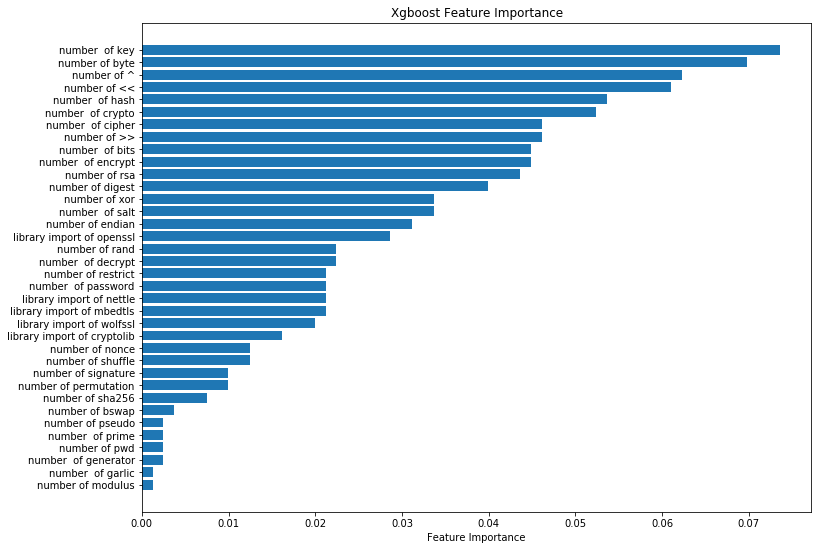

<Figure size 864x648 with 0 Axes>

In [81]:
import matplotlib.pyplot as plt

data=[(k,v) for k,v in get_xgb_imp(gsearch1.best_estimator_,feature_names).items()]
data=sorted(data,key=lambda x : -x[1])
names = [x[0] for x in data]
names[3]='number of <<'
names=list(map(lambda x  : x.replace('of mentions','').replace('nb','number of').replace('of of','of'),names))
values = [x[1] for x in data]
fig, ax = plt.subplots()
y_pos=np.arange(len(names))
                
ax.barh(y_pos, values, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Xgboost Feature Importance')

plt.show()
plt.savefig('feature_importance.png')
#tick_label does the some work as plt.xticks()
# plt.bar(range(len(data)),values,tick_label=names)
# plt.savefig('bar.png')
# plt.show()

In [90]:
# now we know that 130 trees are optima, we will tune tree sepecific hyper parameters like max_depth and min_child_weight
#1 : find the number of trees
param_test = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
         #'n_estimators': range(80,200,5),
        #  'eta' : list(np.arange(0.01,0.2,0.02)),
        # # 'subsample' : list(np.arange(0.5,1,0.1)),
        #  'colsample_bytree' : list(np.arange(0.5,1,0.1))   
        }
def CV_xgb_dict(param_test) : 
        gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, gamma=0, subsample=0.8,n_estimators=130,
         objective= 'binary:logistic',nthread=48, scale_pos_weight=int((len(yTrain)-sum(yTrain['label'])) / sum(yTrain['label'])), seed=0), 
         param_grid = param_test, scoring='recall',iid=True, n_jobs=-1, cv=5, verbose=2)
        gsearch.fit(xTrain_vec_df, yTrain)
        return gsearch
    
CV_xgb_dict(param_test)    

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:  1.5min remaining:   33.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished
/home/hc3040/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hc3040/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=130, n_jobs=1,
                                     nthread=48, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=7, seed=0, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=True, n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_

In [18]:
model = XGBClassifier()
model.fit(xTrain_vec_df, yTrain)

C:\Users\hadri\AppData\Local\Continuum\anaconda3\envs\quant_374\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hadri\AppData\Local\Continuum\anaconda3\envs\quant_374\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [83]:
model=gsearch1.best_estimator_

In [34]:
def test_and_evaluate(model) :
            xTest_vec=xTest.apply(lambda row: build_vector(row), axis=1)
            xTest_vec_df=xTest_vec.to_frame()
            xTest_vec_df.columns=['vec']
            xTest_vec_df=xTest_vec_df.vec.apply(pd.Series)
            xTest_vec_df.columns=feature_names
            #for xgboost :
            regex = re.compile(r"\[|\]|<", re.IGNORECASE)
            xTest_vec_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in xTest_vec_df.columns.values]

            yPred = model.predict(xTest_vec_df)
            M=confusion_matrix(yTest,yPred.reshape(np.array(yTest).shape))
            print('confusion matrix : ')
            print('               ')
            print('      predicted value')
            print('actual', list(M[0]))
            print('value ', list(M[1]))
            print('              ')
            print('Recall for positives = TP/(TP+FN) = ' + str(round(100*M[1][1]/(M[1][1]+M[1][0]),2)) + '%' + ' = ' + 'Conditional probability that we output 1 when the file is indeed crypto')
            print('Recall for negatives = TN/(TN+FP) = '+ str(round(100*M[0][0]/(M[0][0]+M[0][1]),2)) + '%')
            print('Precision for both classes = (TP+TN)/(all) = ' + str(round(100*(M[1][1]+M[0][0])/(sum([M[i][j] for i in [0,1] for j in [0,1]])),2)) + '%')

confusion matrix : 
               
      predicted value
actual [1865, 49]
value  [33, 203]
              
Recall for positives = TP/(TP+FN) = 86.02% = Conditional probability that we output 1 when the file is indeed crypto
Recall for negatives = TN/(TN+FP) = 97.44%
Precision for both classes = (TP+TN)/(all) = 96.19%


In [35]:
import joblib
#save model
joblib.dump(model, "86-96_xgbmodel.joblib") 

# #load saved model
# xgb = joblib.load(filename)

['86-96_xgbmodel.joblib']

In [63]:
xTest_crypto=xTest[(xTest.truelabel==1)]

In [64]:
xTest_crypto_FN=xTest_crypto[xTest_crypto.predlabel==0]

In [66]:
xTest_crypto_FN.to_csv('FN_model_1.csv')

In [67]:
xTest_crypto_FN

,data_source,file_name,is_header,content,truelabel,predlabel
124,crypto_library,files/nettle/memops.h,True,/* memops.h\n\n Copyright (C) 2016 Niels Möl...,1,0
1237,crypto_competitions,catena.c,False,#include <string.h>\n#include <stdio.h>\n#incl...,1,0
154,crypto_library,files/nettle/rsa-pss-sha512-verify.c,False,/* rsa-pss-sha512-verify.c\n\n Verifying sig...,1,0
272,crypto_library,files/nettle/chacha-set-key.c,False,/* chacha-set-key.c\n\n Copyright (C) 2014 N...,1,0
247,crypto_library,files/nettle/ecc-point.c,False,"/* ecc-point.c\n\n Copyright (C) 2013, 2014 ...",1,0
...,...,...,...,...,...,...
196,crypto_library,files/nettle/ripemd160-internal.h,True,/* ripemd160-internal.h\n\n RIPEMD-160 hash ...,1,0
1163,crypto_competitions,blake2-kat.h,True,/*\n BLAKE2 reference source code package - ...,1,0
639,crypto_library,files/libgcrypt/mac-hmac.c,False,/* mac-hmac.c - HMAC glue for MAC API\n * Co...,1,0
146,crypto_library,files/nettle/mini-gmp.h,True,"/* mini-gmp, a minimalistic implementation of ...",1,0
